# 04 - Proyecto Individual: Análisis exploratorio de Datos (EDA)

## Importamos las librerías requeridas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

## Importamos los datasets.

In [2]:
%cd /content/drive/MyDrive/AI Projects/PI01

/content/drive/MyDrive/AI Projects/PI01


In [3]:
games_df = pd.read_parquet('datasets/games.parquet')
reviews_df = pd.read_parquet('datasets/reviews_stt.parquet')
items_df = pd.read_parquet('datasets/items.parquet')
reviews_games_items_df = pd.read_parquet('datasets/reviews_games_items.parquet')
items_games_df = pd.read_parquet('datasets/items_games.parquet')

## Análisis exploratorio.

### Tiempo de juego.

In [4]:
items_games_df.columns

Index(['user_id', 'id', 'item_name', 'item_playtime', 'genre', 'release_date'], dtype='object')

In [5]:
user_playtime = items_games_df.query('release_date >= 2000').groupby(['user_id']).agg({'item_playtime': 'mean'})
user_playtime.describe(percentiles=[.25, .50, .75, .95, .99])[['item_playtime']].T

,count,mean,std,min,25%,50%,75%,95%,99%,max
item_playtime,68670.0,28.35319,54.0576,0.0,7.815529,16.207796,31.800832,88.561473,202.360979,3606.866667


<Axes: xlabel='item_playtime', ylabel='Count'>

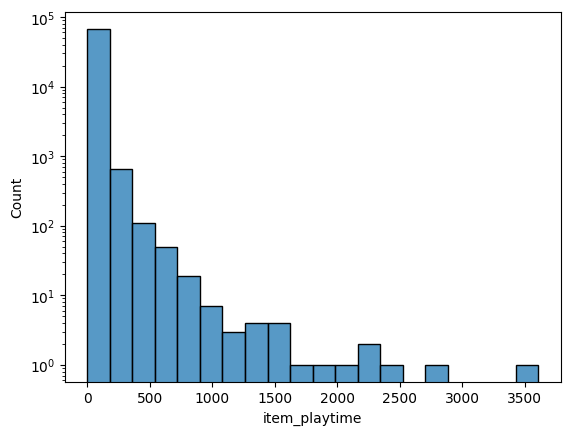

In [6]:
sns.histplot(user_playtime, x='item_playtime', bins=20, log_scale=(False, True))

> Desde el año 2000, se observa que la mitad de los usuarios ha jugado 16.2 horas o menos, mientras que la gran mayoría ha jugado 88.6 horas o menos.

In [7]:
year_playtime = items_games_df.query('release_date >= 2000 & item_playtime <= 89').groupby(['release_date']).agg({'item_playtime': 'sum'})
year_playtime.describe()[['item_playtime']].T

,count,mean,std,min,25%,50%,75%,max
item_playtime,19.0,1.289635e+06,1.283291e+06,102.133333,192455.591667,940814.766667,2.213138e+06,3.926901e+06


In [8]:
year_playtime = year_playtime.reset_index()

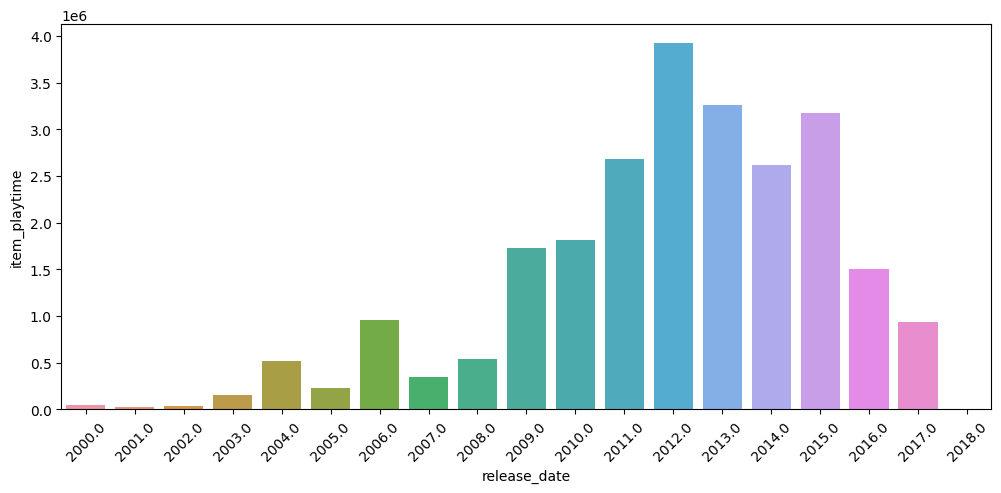

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.barplot(data=year_playtime, x='release_date', y='item_playtime', ax=ax)

plt.xticks(rotation=45)
plt.show()

> Se observa que el tiempo total de juego se parece incrementarse significativamente desde el 2009, alcanzando su pico en el 2012 y manteniéndose hasta el 2015.

### Género.

In [10]:
genre_year = items_games_df.query('release_date >= 2000 & release_date <= 2017').groupby(['release_date', 'genre']).agg({'genre': 'count'})

In [11]:
genre_year.columns = ['genre_count']
genre_year = genre_year.reset_index()

In [12]:
genre_year_wide = genre_year.pivot(index='release_date', columns='genre', values='genre_count')

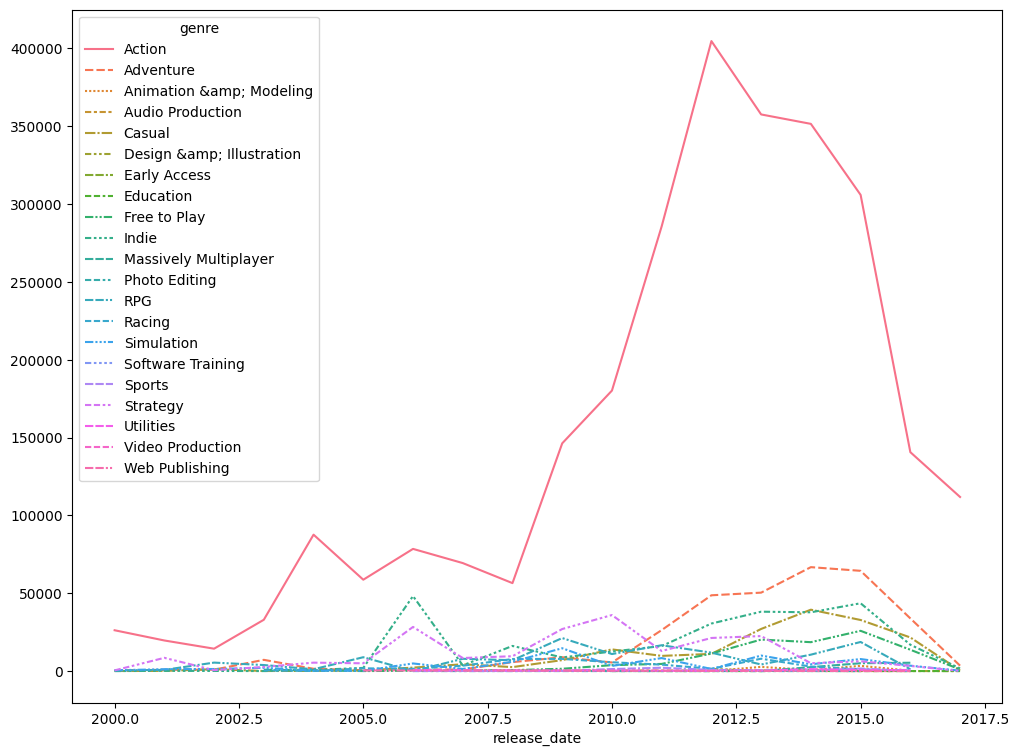

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
sns.lineplot(data=genre_year_wide)

# plt.xticks(rotation=90)
plt.show()

> Se observa la evolución en la demanda de juegos por género entre el 2000 y el 2017. Los juegos del género Action fueron los más demandados a través del tiempo.

### Polaridad de los sentimientos.

In [14]:
sentiment_year = reviews_games_items_df.query('release_date >= 2000 & release_date <= 2017').groupby(['release_date', 'sentiment']).agg({'sentiment': 'count'})

In [15]:
sentiment_year.columns = ['sentiment_count']
sentiment_year = sentiment_year.reset_index()

In [16]:
sentiment_year_wide = sentiment_year.pivot(index='release_date', columns='sentiment', values='sentiment_count')

In [17]:
sentiment_year_wide.columns = ['Negative', 'Neutral', 'Positive']

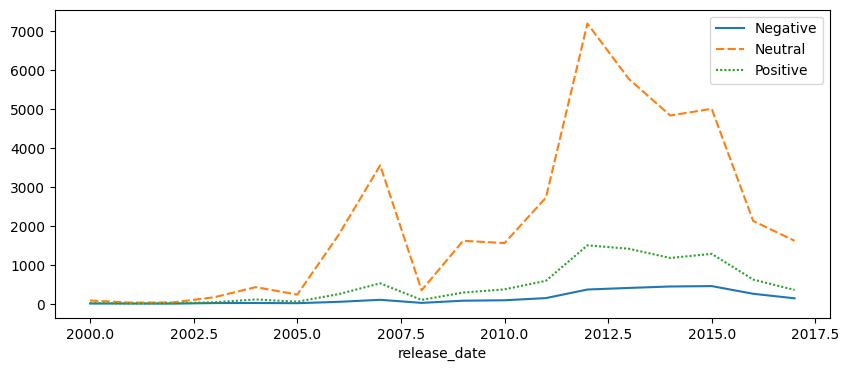

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(data=sentiment_year_wide)

# plt.xticks(rotation=90)
plt.show()

> Se observa que entre el 2000 y 2017 el sentimiento en las recomendaciones de los juegos ha sido sobre todo neutral.

In [19]:
recommend_year = reviews_games_items_df.query('release_date >= 2000 & release_date <= 2017').groupby(['release_date', 'recommend']).agg({'recommend': 'count'})
recommend_year.columns
recommend_year.columns = ['recommend_count']
recommend_year = recommend_year.reset_index()
recommend_year_wide = recommend_year.pivot(index='release_date', columns='recommend', values='recommend_count')
recommend_year_wide.columns = ['NotRecommended', 'Recommended']

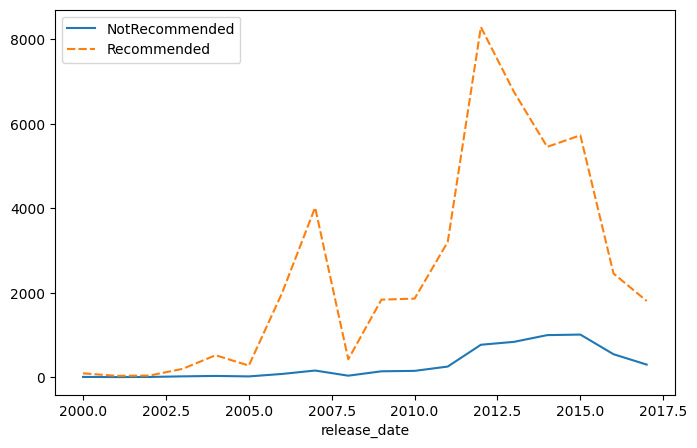

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot(data=recommend_year_wide)

# plt.xticks(rotation=90)
plt.show()

> Se observa que entre el 2000 y 2017 la mayoría de juegos de Steam han sido recomendados por sus mismos usuarios.

### Análisis de palabras.

Creamos un dataset `ml_games` que nos facilite el análisis de las palabras y el posterior ***sistema de recomendación***.

In [21]:
games_df.sample(n=5)

,id,genres,release_date,tags,specs,developer
19225,385130,"[Casual, Indie, Simulation, Sports]",2017-02-09,"[Simulation, Casual, Indie, Sports, Music, Rhy...","[Single-player, Full controller support, Steam...",DarkTigerDevelop
4710,415580,"[Action, Indie, Strategy]",2015-11-02,"[Strategy, Action, Indie]","[Single-player, Downloadable Content, Steam Ac...",Plastic Games
29814,259910,[Simulation],2013-05-28,"[Simulation, Agriculture, Strategy]","[Single-player, Steam Cloud]",Actalogic
7161,460990,None,NaT,"[Casual, VR]","[Single-player, HTC Vive, Oculus Rift, Tracked...",None
3217,296280,"[Indie, Simulation, Strategy]",2015-02-25,"[Indie, Simulation, Strategy, City Builder]",[Single-player],"Flat Earth Games,Epiphany Games"


In [22]:
items_names_df = items_games_df[['id', 'item_name']].drop_duplicates(subset=['id'])
items_names_df.sample(n=5)

,id,item_name
587510,375480,Chronicon
623667,377690,Starlight Vega
47189,259170,Alone in the Dark
8944,269490,Bardbarian
354020,501880,StoneBack | Prehistory


In [23]:
ml_games_df = games_df.join(items_names_df.set_index('id'), on='id', how='right')

In [24]:
ml_games_df = ml_games_df.dropna(subset=['genres', 'tags','specs', 'item_name'])

In [25]:
ml_games_df.specs.map(lambda x: x.tolist())

32104.0             [Multi-player, Valve Anti-Cheat enabled]
32101.0             [Multi-player, Valve Anti-Cheat enabled]
32112.0             [Multi-player, Valve Anti-Cheat enabled]
32106.0             [Multi-player, Valve Anti-Cheat enabled]
32102.0    [Single-player, Multi-player, Valve Anti-Cheat...
                                 ...                        
22786.0    [Single-player, Multi-player, Steam Achievemen...
5645.0     [Single-player, Steam Achievements, Full contr...
23810.0    [Single-player, Steam Achievements, Steam Trad...
5427.0      [Single-player, Steam Achievements, Steam Cloud]
5242.0                                       [Single-player]
Name: specs, Length: 8560, dtype: object

In [26]:
ml_games_df.sample(n=5)

,id,genres,release_date,tags,specs,developer,item_name
24870.0,416310,"[Adventure, Casual, Strategy]",2013-08-21,"[Strategy, Adventure, Casual, Tower Defense]","[Single-player, Steam Trading Cards]",Alawar Entertainment,Goblin Defenders: Steel‘n’ Wood
7226.0,527890,"[Casual, Simulation]",2016-09-12,"[Casual, Simulation]",[Single-player],ViquaSoft,Shop-n-Spree: Shopping Paradise
17533.0,496460,"[Indie, Simulation, Strategy]",2017-05-26,"[City Builder, Strategy, Resource Management, ...","[Single-player, Steam Workshop, Steam Cloud]",Mindillusion,Life is Feudal: Forest Village
27215.0,341260,"[Action, Adventure, Casual, Indie]",2015-03-02,"[Action, Adventure, Indie, Casual, Platformer]","[Single-player, Stats]","Artisiti,Studio Vrtinec",Isaac the Adventurer
3551.0,285740,"[Casual, Indie, Simulation]",2015-04-22,"[Simulation, Dating Sim, Casual, Indie, Funny,...","[Single-player, Steam Achievements, Steam Trad...",Magic Notion,Kitty Powers' Matchmaker


### Creamos el campo `bag of_words`y lo ***lematizamos***.

In [27]:
ml_games_df['bag_of_words'] = ml_games_df.apply(lambda row: np.concatenate((row.genres, row.tags, row.specs)), axis=1)

In [28]:
ml_games_df['bag_of_words'] = ml_games_df.apply(lambda row: np.append(row.bag_of_words, row.specs), axis=1)

In [29]:
ml_games_df['bag_of_words'] = ml_games_df.bag_of_words.map(lambda x: " ".join(x.tolist()).lower())

In [30]:
useful_columns = ['id', 'item_name', 'bag_of_words']
ml_games_df = ml_games_df[useful_columns]
ml_games_df.sample(5)

,id,item_name,bag_of_words
5534.0,421670,CUPID - A free to play Visual Novel,free to play indie rpg simulation free to play...
29051.0,225280,Full Mojo Rampage,action indie rpg action indie rpg rogue-like c...
5491.0,448750,Infinity Saga,action adventure casual indie rpg strategy rpg...
24869.0,418910,Idle Civilization,indie rpg simulation strategy early access ear...
892.0,207250,Cubemen,indie strategy strategy indie tower defense mu...


In [31]:
nlp = spacy.load("en_core_web_sm")

In [32]:
def helper_fn(text):
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
  return lemmas

ml_games_df['bag_of_words_2'] = ml_games_df.bag_of_words.map(helper_fn)

### Visualizamos el ***top 50*** de palabras.

In [33]:
bag_of_words = pd.DataFrame(np.concatenate(ml_games_df.bag_of_words_2.values), columns=['word'])
bag_of_words.shape

(266823, 1)

In [34]:
word_counts_df = bag_of_words.groupby('word').agg({'word': 'count'})
word_counts_df.columns = ['count']
word_counts_df.reset_index(inplace=True)
word_counts_df.sort_values(by='count', ascending=False, inplace=True)

In [35]:
word_counts_df.iloc[:50]

,word,count
367,steam,27603
286,player,21552
349,single,16244
193,indie,10930
13,achievement,9559
55,card,8719
392,trading,8638
15,action,8537
82,controller,7769
376,support,7464


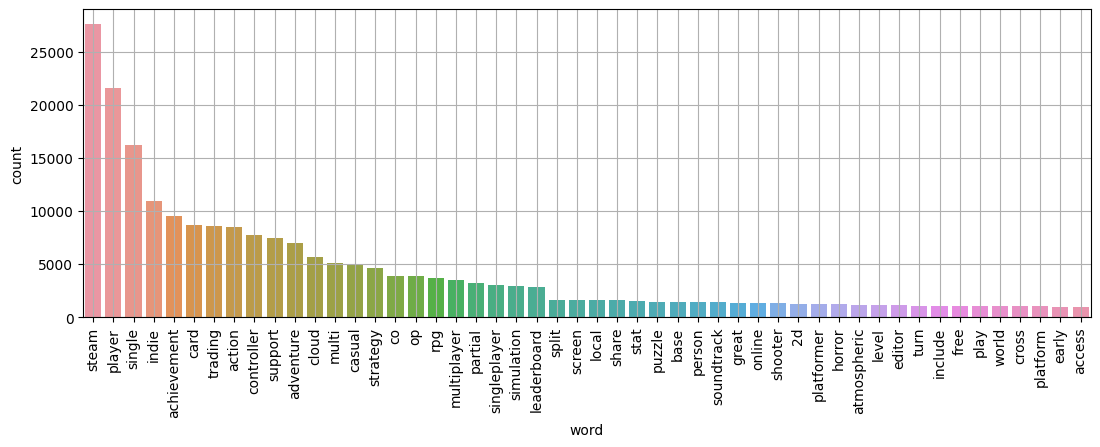

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(13, 4))
sns.barplot(word_counts_df.iloc[:50], x='word', y='count')

plt.xticks(rotation=90)
plt.grid()
plt.show()

### Nube de palabras.

In [37]:
import wordcloud

In [38]:
word_counts_df.set_index('word', inplace=True)

In [39]:
wcloud = wordcloud.WordCloud(width=1024, height=768, contour_width=10, colormap='coolwarm', max_words=100).generate_from_frequencies(frequencies=word_counts_df.to_dict()['count'])

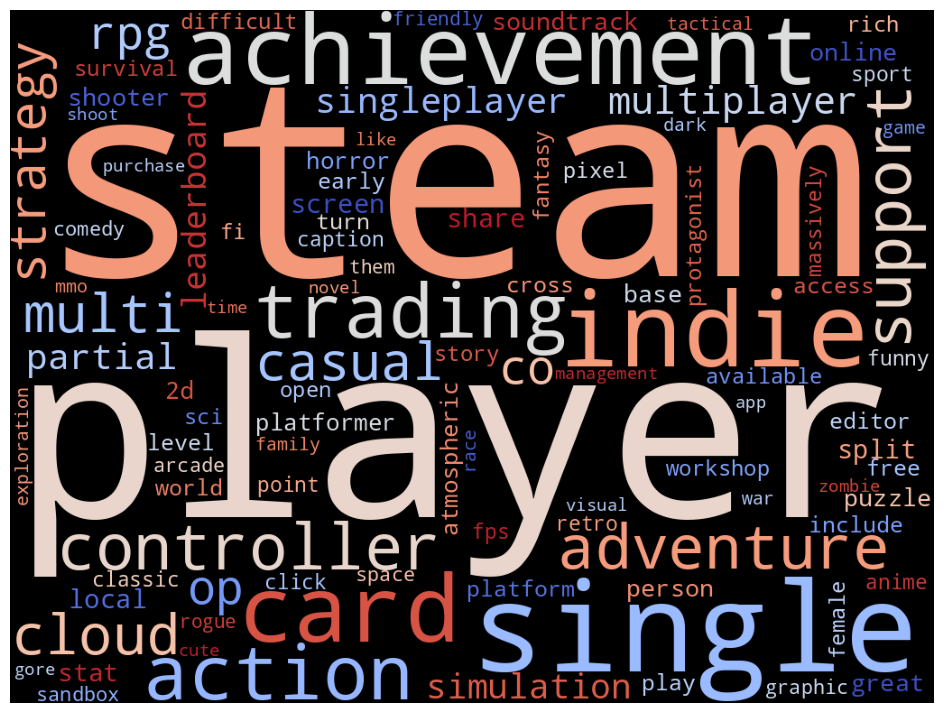

In [40]:
plt.figure(figsize=(12, 9))
plt.imshow(wcloud)
plt.axis('off')
plt.show()

## Guardamos el dataset `ml_games`.

Lo usaremos para construir el sistema de recomendación.

In [42]:
useful_columns = ['id', 'item_name', 'bag_of_words']
ml_games_df[useful_columns].to_parquet('datasets/ml_games.parquet')